d:\Conda\envs\RL_Simple\lib\site-packages\gym\core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
d:\Conda\envs\RL_Simple\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
d:\Conda\envs\RL_Simple\lib\site-packages\gym\core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. Th

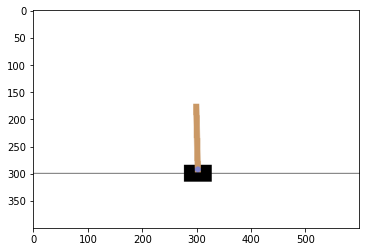

In [1]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

#创建环境
env = gym.make('CartPole-v0')
env.reset()


#打印游戏
def show():
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()


show()

In [2]:
import torch

#定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Softmax(dim=1),
)

model_td = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
)

model(torch.randn(2, 4)), model_td(torch.randn(2, 4))

(tensor([[0.6480, 0.3520],
         [0.5218, 0.4782]], grad_fn=<SoftmaxBackward0>),
 tensor([[ 0.1199],
         [-0.0570]], grad_fn=<AddmmBackward0>))

In [3]:
import random


#得到一个动作
def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)
    #[1, 4] -> [1, 2]
    prob = model(state)

    #根据概率选择一个动作
    action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]

    return action


get_action([1, 2, 3, 4])

1

In [4]:
def get_data():
    states = []
    rewards = []
    actions = []
    next_states = []
    overs = []

    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step(action)

        #记录数据样本
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        next_states.append(next_state)
        overs.append(over)

        #更新游戏状态,开始下一个动作
        state = next_state

    #[b, 4]
    states = torch.FloatTensor(states).reshape(-1, 4)
    #[b, 1]
    rewards = torch.FloatTensor(rewards).reshape(-1, 1)
    #[b, 1]
    actions = torch.LongTensor(actions).reshape(-1, 1)
    #[b, 4]
    next_states = torch.FloatTensor(next_states).reshape(-1, 4)
    #[b, 1]
    overs = torch.LongTensor(overs).reshape(-1, 1)

    return states, rewards, actions, next_states, overs


get_data()

d:\Conda\envs\RL_Simple\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


(tensor([[ 0.0309,  0.0185,  0.0394, -0.0453],
         [ 0.0312, -0.1772,  0.0385,  0.2595],
         [ 0.0277, -0.3728,  0.0437,  0.5641],
         [ 0.0202, -0.1783,  0.0549,  0.2855],
         [ 0.0167, -0.3742,  0.0607,  0.5950],
         [ 0.0092, -0.5701,  0.0726,  0.9061],
         [-0.0022, -0.7661,  0.0907,  1.2207],
         [-0.0175, -0.9623,  0.1151,  1.5403],
         [-0.0368, -1.1586,  0.1459,  1.8666],
         [-0.0599, -0.9653,  0.1832,  1.6226]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0]]),
 tensor([[ 0.0312, -0.1772,  0.0385,  0.2595],
         [ 0.0277, -0.3728,  0.0437,  0.5641],
         [ 0.0202, -0.1783,  0.0549,  0.2855],
         [ 0.0167, -0.3742,  0.0607,  0.5950],
         [ 0.0092, -0.5701,  0.0726,  0.9061],

In [5]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

16.0

In [6]:
#优势函数
def get_advantages(deltas):
    advantages = []

    #反向遍历deltas
    s = 0.0
    for delta in deltas[::-1]:
        s = 0.98 * 0.95 * s + delta
        advantages.append(s)

    #逆序
    advantages.reverse()
    return advantages


get_advantages(range(5))

[8.090483997483998, 8.690100963999999, 8.260044, 6.724, 4.0]

In [7]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    optimizer_td = torch.optim.Adam(model_td.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #玩N局游戏,每局游戏训练M次
    for epoch in range(500):
        #玩一局游戏,得到数据
        #states -> [b, 4]
        #rewards -> [b, 1]
        #actions -> [b, 1]
        #next_states -> [b, 4]
        #overs -> [b, 1]
        states, rewards, actions, next_states, overs = get_data()

        #计算values和targets
        #[b, 4] -> [b, 1]
        values = model_td(states)

        #[b, 4] -> [b, 1]
        targets = model_td(next_states).detach()
        targets = targets * 0.98
        targets *= (1 - overs)
        targets += rewards

        #计算优势,这里的advantages有点像是策略梯度里的reward_sum
        #只是这里计算的不是reward,而是target和value的差
        #[b, 1]
        deltas = (targets - values).squeeze(dim=1).tolist()
        advantages = get_advantages(deltas)
        advantages = torch.FloatTensor(advantages).reshape(-1, 1)

        #取出每一步动作的概率
        #[b, 2] -> [b, 2] -> [b, 1]
        old_probs = model(states)
        old_probs = old_probs.gather(dim=1, index=actions)
        old_probs = old_probs.detach()

        #每批数据反复训练10次
        for _ in range(10):
            #重新计算每一步动作的概率
            #[b, 4] -> [b, 2]
            new_probs = model(states)
            #[b, 2] -> [b, 1]
            new_probs = new_probs.gather(dim=1, index=actions)
            new_probs = new_probs

            #求出概率的变化
            #[b, 1] - [b, 1] -> [b, 1]
            ratios = new_probs / old_probs

            #计算截断的和不截断的两份loss,取其中小的
            #[b, 1] * [b, 1] -> [b, 1]
            surr1 = ratios * advantages
            #[b, 1] * [b, 1] -> [b, 1]
            surr2 = torch.clamp(ratios, 0.8, 1.2) * advantages

            loss = -torch.min(surr1, surr2)
            loss = loss.mean()

            #重新计算value,并计算时序差分loss
            values = model_td(states)
            loss_td = loss_fn(values, targets)

            #更新参数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            optimizer_td.zero_grad()
            loss_td.backward()
            optimizer_td.step()

        if epoch % 50 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, test_result)


train()

0 18.7
50 136.8
100 135.6
150 200.0
200 200.0
250 200.0
300 200.0
350 200.0
400 200.0
450 200.0


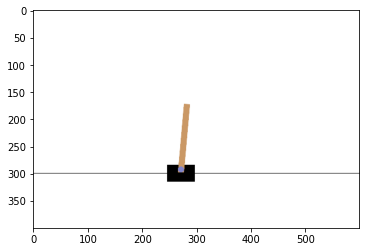

200.0

In [8]:
test(play=True)